<a href="https://colab.research.google.com/github/vipulgote1999/Assignment_GIBots_Pune/blob/main/Train_NN_GiBots_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger


In [ ]:
wandb.login()

wandb: Currently logged in as: vipulgote4 (existence). Use `wandb login --relogin` to force relogin


True

In [ ]:
import pandas as pd
import numpy as np
import os, time,json,sys,random,warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
import keras

In [ ]:
warnings.simplefilter("ignore")
random.seed(42)
np.random.seed(42)
pd.set_option('display.max_columns', None)

In [ ]:
!cp "/content/drive/MyDrive/Assignment data/GI Bots/DATA  Scientist Assignment.zip" /content/

In [ ]:
!unzip "/content/DATA  Scientist Assignment.zip"

Archive:  /content/DATA  Scientist Assignment.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train =pd.read_csv("/content/train.csv")
train_labels = pd.read_csv("/content/trainLabels.csv")
train_labels.drop("id", axis=1,inplace=True)
test_data = pd.read_csv("/content/test.csv")
test_data.columns = train.columns

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  #'mean', 'median', or 'most_frequent'
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bool_transformer = Pipeline(steps=[
#     ('imputer',KNNImputer())
# ])

# here we are preprocessing  numerical and categorical features
preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ], remainder='passthrough',n_jobs=-1)

X = train
y=train_labels[:9999]

In [ ]:
# X_train = pd.DataFrame(preprocessor.fit_transform(train).toarray())
# # y_train = preprocessor.transform(y_train)

# X_train.to_csv("Processed_train.csv")

# Train a model


In [ ]:
!pip install -qq tensorflow_addons numba

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow_addons.metrics import F1Score
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# preprocessor.fit(X_train)
X_train = preprocessor.fit_transform(X_train)
# y_train = preprocessor.fit_transform(y_train)

In [ ]:
X_train.shape, y_train.shape

((7999, 29067), (7999, 33))

In [ ]:
X_train

<7999x29067 sparse matrix of type '<class 'numpy.float64'>'
	with 1167854 stored elements in Compressed Sparse Row format>

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.exp(-0.1)

In [46]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

model = Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1],),sparse=True))
model.add(Dense(512, activation='relu',kernel_regularizer='l2',kernel_initializer='uniform'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu',kernel_initializer='uniform',kernel_regularizer='l1_l2'))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
model.add(Dense(33, activation='sigmoid'))

adamw_opt = keras.optimizers.AdamW(learning_rate=0.01)
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="binary_crossentropy",# optimizer=adamw_opt,
              optimizer=opt,
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(patience=10,restore_best_weights=True)
lr_callback = keras.callbacks.LearningRateScheduler(scheduler)

ReduceLROnPlatea_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              patience=3, min_lr=0.0001)

run = wandb.init(
    project = "GiBots-finetune"
)
# model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
model.fit(X_train.todense(), y_train.values, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stopping,ReduceLROnPlatea_lr,WandbMetricsLogger(log_freq=10,)])

run.finish()

Epoch 1/100
200/200 [==============================] - 5s 18ms/step - loss: 4.8521 - accuracy: 0.5476 - val_loss: 1.7429 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 2/100
200/200 [==============================] - 4s 18ms/step - loss: 1.7727 - accuracy: 0.5599 - val_loss: 1.8558 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 3/100
200/200 [==============================] - 4s 19ms/step - loss: 1.7687 - accuracy: 0.5599 - val_loss: 1.7775 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 4/100
200/200 [==============================] - 4s 21ms/step - loss: 1.7608 - accuracy: 0.5599 - val_loss: 1.7260 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 5/100
200/200 [==============================] - 5s 23ms/step - loss: 1.7402 - accuracy: 0.5599 - val_loss: 1.8723 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 6/100
200/200 [==============================] - 4s 19ms/step - loss: 1.7620 - accuracy: 0.5599 - val_loss: 1.6651 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 7/100
200/200 [==============================] - 3s 

batch/accuracy,▁▃▅▃▃▄▄▄▄▃▄▄▄▁▃█▆▆▆▆▇▆█▇▆▇▆▆▆▆▇▆▇▇▅▆▇▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,█████████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▃▃▃▃▃▃▃▄▇▆▇█▇██▇█▇███▇██▇
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,█████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▄▁▆▇▇▇▇▇███▇█▇██▇███
epoch/val_loss,▇██▇█▇██▇▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## To View Training Dashboard click on below link:
https://wandb.ai/existence/GiBots-finetune

In [47]:
prep_test_data = preprocessor.transform(test_data)
prep_test_data.shape

(1999, 29067)

63/63 [==============================] - 59s 3ms/step


<Axes: ylabel='Count'>

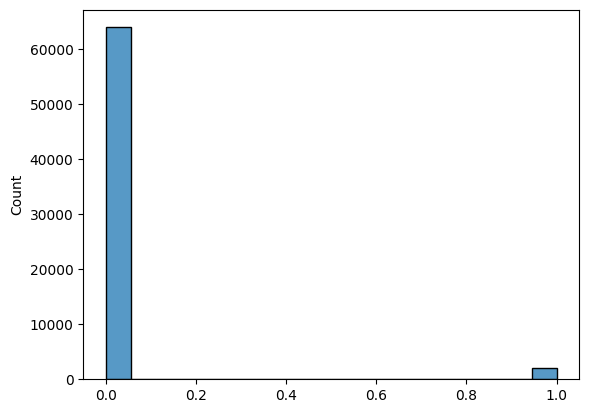

In [48]:
import seaborn as sns
preds = model.predict(prep_test_data)
prep_sub_ids = [str(int(num)) + '_y' + str(int(i)) for num in test_data.id for i in range(1, 34)]
flatten_pred_list = preds.flatten()
new_arr = [1 if i>=0.5 else 0 for i in flatten_pred_list]

# sns.distplot(flatten_pred_list)
sns.histplot(new_arr)

<Axes: ylabel='Density'>

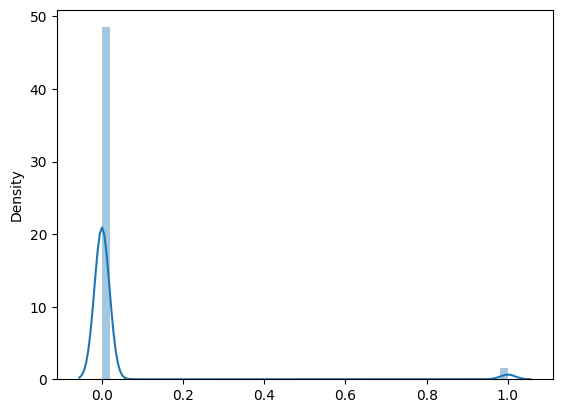

In [49]:
sns.distplot(new_arr)

<Axes: ylabel='Density'>

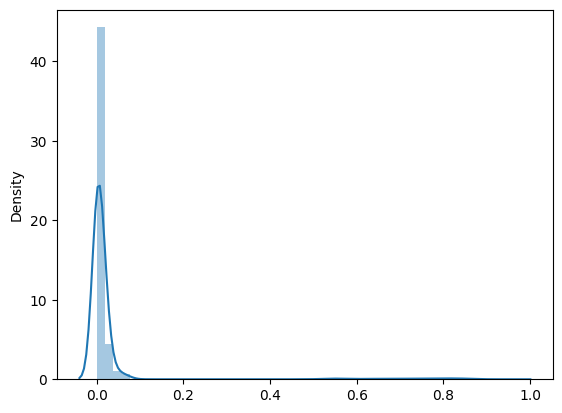

In [50]:
sns.distplot(flatten_pred_list)

In [52]:
submission_df = pd.DataFrame([prep_sub_ids,new_arr]).T
submission_df.columns = ["id","pred"]
# submission_df.head()

submission_df.to_csv("NN_model_submission_file_v3.csv",index=False)